In [ ]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from PIL import Image


In [ ]:
# Define paths and parameters
base_dir = "/content/unzipped_datasets"
categories = ["beach", "mountain", "person", "sunrise"]

# Resized dataset paths
train_dir = f"{base_dir}/train_resized"
val_dir = f"{base_dir}/val_resized"
test_dir = f"{base_dir}/test_resized"

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 20


In [ ]:
# Unzip dataset
zip_files = ["/content/train.zip", "/content/val.zip", "/content/test.zip"]
output_dir = "/content/unzipped_datasets"

os.makedirs(output_dir, exist_ok=True)

for zip_file in zip_files:
    if os.path.exists(zip_file):
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(output_dir)
            print(f"Unzipped {zip_file} to {output_dir}")
    else:
        print(f"File not found: {zip_file}")

print("All datasets unzipped successfully!")


Unzipped /content/train.zip to /content/unzipped_datasets
Unzipped /content/val.zip to /content/unzipped_datasets
Unzipped /content/test.zip to /content/unzipped_datasets
All datasets unzipped successfully!


In [ ]:
for split in ["train", "val", "test"]:
    split_dir = os.path.join(output_dir, split)
    if os.path.exists(split_dir):
        print(f"Categories in {split}: {os.listdir(split_dir)}")
    else:
        print(f"Split directory not found: {split_dir}")

Categories in train: ['person', 'mountain', 'sunrise', 'beach']
Categories in val: ['person', 'mountain', 'sunrise', 'beach']
Categories in test: ['person', 'mountain', 'sunrise', 'beach']


In [ ]:
import os
from PIL import Image
import numpy as np

# Define the function to preprocess images
def preprocess_images(input_dir, output_dir, target_size=(224, 224)):
    """
    Preprocess images: resize and save them to the output directory.

    Args:
        input_dir (str): Path to the input image directory.
        output_dir (str): Path to the output directory where processed images will be saved.
        target_size (tuple): Desired image size (height, width).
    """
    os.makedirs(output_dir, exist_ok=True)

    for category in os.listdir(input_dir):
        category_path = os.path.join(input_dir, category)
        output_category_path = os.path.join(output_dir, category)

        # Ensure category output folder exists
        os.makedirs(output_category_path, exist_ok=True)

        for img_name in os.listdir(category_path):
            if img_name.lower().endswith(('png', 'jpg', 'jpeg')):
                # Load image
                img_path = os.path.join(category_path, img_name)
                img = Image.open(img_path).convert('RGB')
                img = img.resize(target_size)
                img = np.array(img)

                # Save processed image to output directory
                output_img_path = os.path.join(output_category_path, img_name)
                Image.fromarray(img).save(output_img_path)
                print(f"Processed image saved: {output_img_path}")

    print("Image preprocessing completed.")


In [ ]:
base_dir = "/content/unzipped_datasets"  # Path to the root dataset folder
train_dir = "/content/train_processed"   # Output directory for processed train images
val_dir = "/content/val_processed"       # Output directory for processed validation images
test_dir = "/content/test_processed"     # Output directory for processed test images

# Apply preprocessing to train, val, and test datasets
preprocess_images(f"{base_dir}/train", train_dir)
preprocess_images(f"{base_dir}/val", val_dir)
preprocess_images(f"{base_dir}/test", test_dir)

Streaming output truncated to the last 5000 lines.
Processed image saved: /content/train_processed/mountain/1LSA3KBR8RB3.jpg
Processed image saved: /content/train_processed/mountain/M6TRU79FPJB5.jpg
Processed image saved: /content/train_processed/mountain/BJ9AILXNOKTQ.jpg
Processed image saved: /content/train_processed/mountain/T11QI7MZ1PS9.jpg
Processed image saved: /content/train_processed/mountain/AK42L38Q0FPC.jpg
Processed image saved: /content/train_processed/mountain/DCN2ULSOCNZ9.jpg
Processed image saved: /content/train_processed/mountain/RIGBNURNMNAU.jpg
Processed image saved: /content/train_processed/mountain/PDT6244KW935.jpg
Processed image saved: /content/train_processed/mountain/TK7OYJ3T1DP4.jpg
Processed image saved: /content/train_processed/mountain/ISNFURDJHRJN.jpg
Processed image saved: /content/train_processed/mountain/Y8ID3E1V39E8.jpg
Processed image saved: /content/train_processed/mountain/GEBJLJ9FWL7E.jpg
Processed image saved: /content/train_processed/mountain/J1N1

In [ ]:
# Augment and normalize images
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Define data generators for train, validation, and test sets
train_gen = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_test_datagen.flow_from_directory(
    directory=val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = val_test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 3372 images belonging to 4 classes.
Found 518 images belonging to 4 classes.
Found 1688 images belonging to 4 classes.


In [ ]:
# Use MobileNetV2 as the base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom classification head
num_classes = len(categories)
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='sigmoid')  # Sigmoid for multi-label classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # For multi-label classification
              metrics=['accuracy'])

# Display model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Example model definition (modify based on your requirement)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(categories), activation='sigmoid')  # Use sigmoid for multi-label classification
])

# Learning rate (optional)
LEARNING_RATE = 0.0001

# Compile the model
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='binary_crossentropy',  # Binary cross-entropy for multi-label classification
              metrics=['accuracy'])

# Now you can train the model using model.fit
history = model.fit(
    train_gen,  # Replace with your training data generator
    validation_data=val_gen,  # Replace with your validation data generator
    epochs=10
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


211/211 ━━━━━━━━━━━━━━━━━━━━ 50s 206ms/step - accuracy: 0.7435 - loss: 0.3997 - val_accuracy: 0.8958 - val_loss: 0.1753
Epoch 2/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 40s 186ms/step - accuracy: 0.8829 - loss: 0.1779 - val_accuracy: 0.9073 - val_loss: 0.1450
Epoch 3/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 41s 186ms/step - accuracy: 0.8997 - loss: 0.1454 - val_accuracy: 0.9305 - val_loss: 0.1091
Epoch 4/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 40s 185ms/step - accuracy: 0.9119 - loss: 0.1279 - val_accuracy: 0.9324 - val_loss: 0.1111
Epoch 5/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 42s 187ms/step - accuracy: 0.9034 - loss: 0.1419 - val_accuracy: 0.9344 - val_loss: 0.1131
Epoch 6/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 41s 185ms/step - accuracy: 0.9239 - loss: 0.1143 - val_accuracy: 0.9402 - val_loss: 0.0933
Epoch 7/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 41s 187ms/step - accuracy: 0.9229 - loss: 0.1099 - val_accuracy: 0.9382 - val_loss: 0.0899
Epoch 8/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 41s 186ms/step - accuracy: 0.9258 - loss: 0.1055 - val

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_gen, steps=test_gen.samples // BATCH_SIZE)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8846 - loss: 0.1537
Test Loss: 0.07768606394529343
Test Accuracy: 0.9452381134033203


In [ ]:
# Save the trained model
model.save("/content/saved_models.h5")
print("Model saved successfully!")


Model saved successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


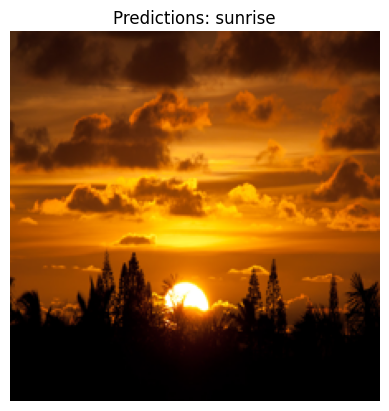

Predicted Labels: ['sunrise']
Predicted Probabilities: [5.4222811e-04 4.6354258e-03 4.4157941e-06 9.9968207e-01]
Generated Caption: "A blazing farewell to the day."


In [ ]:
# Import necessary libraries
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from tensorflow.keras.models import load_model

# Constants
IMG_SIZE = (224, 224)  # Image resizing dimensions
categories = ["beach", "mountain", "person", "sunrise"]
excel_path = "/content/captions.xlsx"  # Path to captions Excel file

# Load captions from Excel file
captions_df = pd.read_excel(excel_path)

# Helper function to pick a random caption
def pick_random_caption(predicted_labels, captions_df):
    """
    Selects a random caption from the Excel file based on predictions.

    Args:
        predicted_labels (list): List of predicted categories (e.g., ["mountain", "sunrise"]).
        captions_df (DataFrame): DataFrame containing captions for each category or combination.

    Returns:
        str: Randomly selected caption.
    """
    # Sort predicted labels to match column naming convention
    sorted_labels = sorted(predicted_labels)
    possible_column_names = [
        " + ".join(sorted_labels),  # Default sorted column name
        " + ".join(predicted_labels)  # Original order from prediction
    ]

    # Iterate over possible column names to find a match
    for column_name in possible_column_names:
        if column_name in captions_df.columns:
            captions = captions_df[column_name].dropna().tolist()  # Drop empty rows
            if captions:
                return random.choice(captions)

    return f"No matching column found for {', '.join(predicted_labels)}."

# Function to predict and display results
def predict_image(image_path, model, categories, threshold=0.5):
    """
    Predict categories for the given image and display results.

    Args:
        image_path (str): Path to the image file.
        model (Model): Trained Keras model for classification.
        categories (list): List of category labels.
        threshold (float): Probability threshold for category prediction.
    """
    # Preprocess the image
    img = Image.open(image_path).convert('RGB').resize(IMG_SIZE)
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict category probabilities
    predictions = model.predict(img_array)
    predicted_labels = [categories[i] for i, prob in enumerate(predictions[0]) if prob > threshold]

    # Display image with predictions
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predictions: {', '.join(predicted_labels)}")
    plt.show()

    # Print predictions and probabilities
    print("Predicted Labels:", predicted_labels)
    print("Predicted Probabilities:", predictions[0])

    # Generate a caption
    caption = pick_random_caption(predicted_labels, captions_df)
    print(f"Generated Caption: {caption}")

# Load the trained model (replace 'model_path.h5' with the actual model path)
model = load_model("/content/saved_models.h5")

# Test prediction on a sample image
sample_image_path = "test7.jpg"  # Replace with the path to your test image
predict_image(sample_image_path, model, categories, threshold=0.3)
